In [2]:
import os
import pickle
import pandas as pd 
import numpy as np 
from selenobot.utils import RESULTS_DIR, DATA_DIR, dataframe_to_fasta
from selenobot import kegg
from selenobot.sequences import * 
import fabapi
import matplotlib.pyplot as plt
import time
import requests
import wget
import subprocess
import warnings 

warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

VAL_DIR = os.path.join(DATA_DIR, 'validation')
ko = 'K03738'

What are all the KEGG ortholog groups which contain at least one known selenoprotein?

In [3]:
kegg_ids = pd.read_csv(os.path.join(VAL_DIR, 'sec_kegg_ids.tsv'), delimiter='\t')
print('Total number of selenoproteins in UniProt:', len(kegg_ids))
print('Number of known selenoproteins in UniProt missing a KEGG accession:', kegg_ids['KEGG'].isnull().sum())
kegg_ids = [acc.replace(';', '') for acc in kegg_ids['KEGG'].dropna().unique()]
print('Number of KEGG accessions available for known selenoproteins in UniProt:', len(kegg_ids))

# kegg_df = kegg.get_metadata_by_genes(kegg_accessions)
# kegg_df.set_index('id').to_csv(os.path.join(VAL_DIR, 'sec_kegg_data.csv'))

Total number of selenoproteins in UniProt: 19389
Number of known selenoproteins in UniProt missing a KEGG accession: 16506
Number of KEGG accessions available for known selenoproteins in UniProt: 2877


In [4]:
ko_groups = pd.read_csv(os.path.join(VAL_DIR, 'sec_kegg_data.csv'))['ko'].dropna().unique()

for ko in ko_groups:
    if not os.path.exists(os.path.join(VAL_DIR, ko)):
        os.mkdir(os.path.join(VAL_DIR, ko))
        df = kegg.get_metadata_by_ko(ko)
        df.set_index('id').to_csv(os.path.join(VAL_DIR, ko, 'metadata.csv'))
    

get_metadata_by_ko: Retrieving genes from KEGG for KO group K03672...: 100%|██████████| 2160/2160 [27:03<00:00,  1.33it/s]
get_metadata_by_ko: Retrieving genes from KEGG for KO group K09181...: 100%|██████████| 2029/2029 [25:13<00:00,  1.34it/s]
get_metadata_by_ko: Retrieving genes from KEGG for KO group K07022...: 100%|██████████| 213/213 [02:32<00:00,  1.39it/s]
get_metadata_by_ko: Retrieving genes from KEGG for KO group K00059...:   6%|▌         | 2080/36329 [52:33<14:25:17,  1.52s/it]


ConnectionError: ('Connection aborted.', OSError(101, 'Network is unreachable'))

# Validation on KEGG sequences

The idea behind this approach to validation is to look at the members of a KO group which is known to contain selenoproteins. Some of these members will (hopefully) be predicted to be truncated selenoproteins. I can extend these predictions, and then align them to known selenoproteins in the KO group. To do this, I will need to:
1. Find a KO group with some predicted selenoproteins and some known selenoproteins. These groups will be the most likely to not have false positives, I think. 
2. Obtain the genomes from which the proteins were derived, and extend the predicted selenoproteins to the next stop codon. 
3. Write the extended sequences to a FASTA file and align them to the known selenoproteins in the KO group. 

**Possible issues:** I am not sure if this will be misleading, as it could be that some of the shorter proteins in the KO group were once selenoproteins, and then some kind of mutation truncated them -- i.e. they could actually just be truncated, but still functional. 

In [2]:
# embeddings_df = pd.read_csv(os.path.join(VAL_DIR, ko, 'embeddings.csv'), index_col=0)
# embeddings_df['id'] = [s.split(';')[0].split('=')[1] for s in embeddings_df['id']]
# embeddings_df = embeddings_df.set_index('id')
# embeddings_df.to_csv(os.path.join(VAL_DIR, ko, 'embeddings.csv'))

In [10]:
# Start out by analyzing KO8348, the formate dehydrogenases.
# One thing to do would be to download the sequences from KEGG, and look at what the model predicts. 

if not os.path.exists(os.path.join(VAL_DIR, ko, 'metadata.csv')):
    df = kegg.get_metadata_by_ko(ko)
    df.set_index('id').to_csv(os.path.join(VAL_DIR, ko, 'metadata.csv'))
metadata_df = pd.read_csv(os.path.join(VAL_DIR, ko, 'metadata.csv'))
dataframe_to_fasta(metadata_df.rename(columns={'aa_seq':'seq'}).drop(columns=['nt_seq']), os.path.join(VAL_DIR, ko, 'genes.fa'))

# Some of the genome IDs are duplicated, so make sure not to download twice. 
genome_ids = {row.organism.split()[0]:row.genome_id for row in metadata_df.itertuples()}
for organism, genome_id in genome_ids.items():
    if not os.path.exists(os.path.join(VAL_DIR, 'genomes', f'{organism}.fn')):
        try:
            kegg.get_genome(genome_id)
        except:
            continue


get_metadata_by_ko: Retrieving genes from KEGG...: 100%|██████████| 1694/1694 [23:45<00:00,  1.19it/s]


get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/sse.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/mah.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/mbur.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/cyq.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/cza.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/cyy.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/twn.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/aeh.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/genomes/nax.fn
get_genome: Saved genome to /home/prichter/Documents/selenobot/selenobot/../data/val2/geno

I am a little worried about data leakage, as it seems as though some of the sequences from KEGG are cross-listed in UniProt (where I got all the model training data). I also think the level of model certainty about the predictions is kind of suspicious, and the fact that there seems to be a million false positives. 

In [11]:
training_data_ids = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), usecols=['id']).values.ravel()
training_data_ids = np.array([id_.replace('[1]', '') for id_ in training_data_ids]) # Remove the truncation labels. 

kegg_ids = pd.read_csv(os.path.join(VAL_DIR, ko, 'metadata.csv'), usecols=['uniprot_id']).values.ravel()

In [12]:
print('Number of KEGG ids which are present in the training data:', np.sum(np.isin(kegg_ids, training_data_ids)))

print()
for id_ in kegg_ids[np.isin(kegg_ids, training_data_ids)]:
    print(id_)

Number of KEGG ids which are present in the training data: 2

Q5JE15
Q56303


In [13]:
input_path = os.path.join(VAL_DIR, ko, 'genes.fa')
output_path = os.path.join(VAL_DIR, ko, 'embeddings.csv')

subprocess.run(f'python ../scripts/embed.py {input_path} {output_path}', shell=True, check=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
PlmEmbedder.__call__:   0%|          | 0/1694 [00:00<?, ?it/s]

Generating PLM embeddings...


PlmEmbedder.__call__: 100%|██████████| 1694/1694 [6:29:15<00:00, 13.79s/it]  


Done.
Writing embeddings to temporary file...
Done
Combining metadata and PLM embeddings...


add_embeddings: 100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Done.
Embedding written to /home/prichter/Documents/selenobot/selenobot/../data/val2/K03738/embeddings.csv.


CompletedProcess(args='python ../scripts/embed.py /home/prichter/Documents/selenobot/selenobot/../data/val2/K03738/genes.fa /home/prichter/Documents/selenobot/selenobot/../data/val2/K03738/embeddings.csv', returncode=0)

In [ ]:
input_path = os.path.join(VAL_DIR, ko, 'embeddings.csv')
output_path = os.path.join(VAL_DIR, ko, 'predictions.csv')

subprocess.run(f'python ../scripts/predict.py {input_path} {output_path}', shell=True, check=True)

CompletedProcess(args='python ../scripts/predict.py /home/prichter/Documents/selenobot/selenobot/../data/val2/K08348/embeddings.csv /home/prichter/Documents/selenobot/selenobot/../data/val2/K08348/predictions.csv', returncode=0)

In [6]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, ko, 'predictions.csv'))
predictions_df['known_selenoprotein'] = predictions_df.seq.str.contains('U')
# Interesting that the model does not flag full-length selenoproteins! A good thing. 
sec_predictions_df = predictions_df[predictions_df.prediction == 1]

print(len(sec_predictions_df), f'predicted selenoproteins in KO group {ko}.')
print(np.sum(sec_predictions_df.known_selenoprotein), 'predicted selenoproteins are known full-length selenoproteins.')

161 predicted selenoproteins in KO group K08348.
0 predicted selenoproteins are known full-length selenoproteins.


In [82]:
def extend_predicted_selenoproteins(predictions_df:pd.DataFrame, path:str=os.path.join(VAL_DIR, ko, 'extended.fa')):

    fasta_df = []

    rows = list(predictions_df.itertuples())
    for row in tqdm(rows, desc='extend_predicted_selenoproteins'):

        id_ = getattr(row, 'id')
        organism = id_.split(':')[0] # Extract the organism code from the ID. 

        metadata_df = kegg.get_metadata_by_organism(organism)
        genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', f'{organism}.fn'), parser=None)
        metadata_df['scaffold_id'] = genome_df['id'][0] # Manually set the scaffold ID, as we are working with closed genomes. 
        cseq = ContextSequence(id_, metadata_df, genome_df=genome_df)

        cseq = cseq.extend()
        fasta_df.append(cseq.fasta(file_type='fa')) # Get the necessary info for generating a FASTA file. 
    
    fasta_df = pd.DataFrame(fasta_df)
    print(f'extend_predicted_selenoproteins: Writing extended selenoproteins to {path}.')
    dataframe_to_fasta(fasta_df, path=path)

extend_predicted_selenoproteins(predictions_df)   

predictions_df['length'] = predictions_df.seq.apply(len)
predictions_df['known_selenoprotein'] = predictions_df.seq.str.contains('U')

reference_df = predictions_df[predictions_df.known_selenoprotein].drop(columns=[col for col in predictions_df.columns if 'num' in col])
dataframe_to_fasta(reference_df, path=os.path.join(VAL_DIR, ko, 'reference.fa'))
        

extend_predicted_selenoproteins: 100%|██████████| 154/154 [06:12<00:00,  2.42s/it]

extend_predicted_selenoproteins: Writing extended selenoproteins to /home/prichter/Documents/selenobot/selenobot/../data/val2/K08348/extended.fa.


In [35]:
# print('Size of predictions DataFrame before merge:', len(predictions_df))
# print('Size of metadata DataFrame:', len(metadata_df))
predictions_df = predictions_df.merge(pd.read_csv(os.path.join(VAL_DIR, ko, 'metadata.csv')), on='id', how='inner')
# print('Size of predictions DataFrame after merge:', len(predictions_df))
# predictions_df['length'] = predictions_df.stop - predictions_df.start

predictions_df['length'] = predictions_df.aa_seq.apply(len)
predictions_df.sort_values('length')

,id,model_output,prediction,seq,known_selenoprotein,start,stop,strand,aa_seq,nt_seq,genome_id,ncbi_id,uniprot_id,organism,ko,length
602,atl:Athai_16180,2.624309e-10,0.0,MIEARVLVTDRVTPLTVAGRTMHQIGLPYHWGPTGYSTGDAANELT...,False,1813217,1813513,-,MIEARVLVTDRVTPLTVAGRTMHQIGLPYHWGPTGYSTGDAANELT...,gtgatcgaggcccgggtactggtcaccgaccgcgtcacgccgctga...,gn:T07045,BCJ34115,A0A7R7DM79,atl Actinocatenispora thailandica,K08348,98
507,etd:ETAF_3338,9.999998e-01,1.0,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,False,3451947,3452489,+,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,atggcaggaacaacggcagcggtgctgggcttcgccccgtcgctgg...,gn:T02091,ADM43127,A0A0H3DUF3,etd Edwardsiella tarda FL6-60,K08348,180
583,cju:C8J_1415,9.999974e-01,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,False,1434200,1434742,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T00597,ABV53013,NaN,cju Campylobacter jejuni subsp. jejuni 81116,K08348,180
584,cjn:ICDCCJ07001_1438,9.999974e-01,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,False,1478810,1479352,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T01372,ADT66754,NaN,cjn Campylobacter jejuni subsp. jejuni ICDCCJ...,K08348,180
504,etr:ETAE_3337,9.999998e-01,1.0,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,False,3515835,3516377,+,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,atggcaggaacaacggcagcggtgctgggcttcgccccgtcgctgg...,gn:T01121,ACY86168,NaN,etr Edwardsiella piscicida EIB202,K08348,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,vff:VITFI_CDS0376,7.493426e-03,0.0,MASPTHTPRSAEPAQVSRRQFFKISAAGIGGTSMALLGVAPQMAHA...,False,398688,401795,-,MASPTHTPRSAEPAQVSRRQFFKISAAGIGGTSMALLGVAPQMAHA...,atggcttcccccacccacaccccccgcagcgcggagcctgcccagg...,gn:T04960,ASM76155,A0A221KB17,vff Vitreoscilla filiformis,K08348,1035
571,sws:I6J16_07240,3.063316e-03,0.0,MELSRRSFLKRGLILGTTPVAAGLASTAAMAASSTKKPYKLANVQE...,False,1877976,1881086,-,MELSRRSFLKRGLILGTTPVAAGLASTAAMAASSTKKPYKLANVQE...,atggaactttctcgcagaagcttcctcaagcgcggcctgattctcg...,gn:T07195,QQS88958,NaN,sws Sutterella wadsworthensis,K08348,1036
560,nbl:GJV52_02430,4.559372e-03,0.0,MNVSRRQFFKVTAAGAGASGLAVMGMMPTNAWAEVRQYKLLRATET...,False,459955,463071,-,MNVSRRQFFKVTAAGAGASGLAVMGMMPTNAWAEVRQYKLLRATET...,atgaatgtatcaagacggcagttttttaaagtaacggccgccggtg...,gn:T06557,QGL24485,NaN,nbl Neisseria brasiliensis,K08348,1038
463,pva:Pvag_3327,2.866518e-04,0.0,MTNVLTLVNLQSTRTAILQGFAMEPIKKNDKMQINRRSFFKICAGG...,False,3516158,3519301,-,MTNVLTLVNLQSTRTAILQGFAMEPIKKNDKMQINRRSFFKICAGG...,atgactaacgtgttgaccctggtcaacttacagtcaaccaggactg...,gn:T01326,ADO11465,NaN,pva Pantoea vagans C9-1,K08348,1047


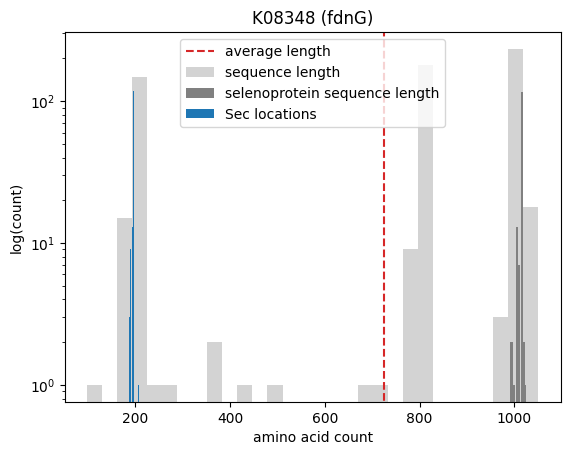

In [14]:
# Where in the sequences do selenoproteins occur?
sec_location = metadata_df.aa_seq.str.find('U').values
sec_location = sec_location[sec_location > -1] # Remove cases where U is not found.
average_length = df.aa_seq.apply(len).mean()
lengths = df.aa_seq.apply(len).values
sec_lengths = lengths[df.aa_seq.str.contains('U')]

fig, ax = plt.subplots()
ax.hist(lengths, bins=30, color='lightgray', log=True)
ax.hist(sec_lengths, color='gray', log=True)
ax.hist(sec_location, color='tab:blue', log=True)
ax.vlines(average_length, ymin=0, ymax=ax.get_ylim()[-1], color='tab:red', linestyles='--')
# ax.legend(['Sec locations', 'sequence length', 'average length'])
ax.legend(['average length', 'sequence length', 'selenoprotein sequence length', 'Sec locations'])
ax.set_ylabel('log(count)')
ax.set_xlabel('amino acid count')
ax.set_title('K08348 (fdnG)')
plt.show()

In [70]:
# What are the lengths of the predicted selenoproteins like?
predictions_df = pd.read_csv(os.path.join(VAL_DIR, ko, 'predictions.csv'))
sec_predictions_df = predictions_df[predictions_df.prediction == 1]
sec_predictions_df = sec_predictions_df.merge(pd.read_csv(os.path.join(VAL_DIR, ko, 'metadata.csv')), on='id')
sec_predictions_df['length'] = sec_predictions_df.aa_seq.apply(len) 
sec_predictions_df.sort_values('length')

,id,model_output,prediction,seq,start,stop,strand,aa_seq,nt_seq,genome_id,ncbi_id,uniprot_id,organism,ko,length
158,cjq:UC78_1444,0.999997,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,1422439,1422981,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T03745,AJP35923,NaN,cjq Campylobacter jejuni subsp. jejuni 35925B2,K08348,180
157,cjm:CJM1_1456,0.999997,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,1425089,1425631,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T01855,ADN91645,NaN,cjm Campylobacter jejuni subsp. jejuni M1,K08348,180
156,cjn:ICDCCJ07001_1438,0.999997,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,1478810,1479352,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T01372,ADT66754,NaN,cjn Campylobacter jejuni subsp. jejuni ICDCCJ...,K08348,180
155,cju:C8J_1415,0.999997,1.0,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,1434200,1434742,-,MSSVGENIKLTRRSFLKMAALSSLATPLLARSETLREASADELKEA...,atgtcaagtgtaggtgaaaatatcaagcttacgcgtcgttcttttc...,gn:T00597,ABV53013,NaN,cju Campylobacter jejuni subsp. jejuni 81116,K08348,180
142,etr:ETAE_3337,1.000000,1.0,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,3515835,3516377,+,MAGTTAAVLGFAPSLALAQTRQYKLLRAKETRNTCTYCSVGCGLLM...,atggcaggaacaacggcagcggtgctgggcttcgccccgtcgctgg...,gn:T01121,ACY86168,NaN,etr Edwardsiella piscicida EIB202,K08348,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,kus:B9G99_04270,1.000000,1.0,MTVNVTRRQFFKLGAAGVASSSMAMMGFAPESAEASVRQFKLTHAK...,903331,903924,-,MTVNVTRRQFFKLGAAGVASSSMAMMGFAPESAEASVRQFKLTHAK...,atgacggttaatgtaacccgaagacagttcttcaagctgggggcgg...,gn:T04839,ARS52190,A0A2Z2HA12,kus Kushneria konosiri,K08348,197
64,enf:AKI40_3159,1.000000,1.0,MRKAMDVSRRQFFRICAGGMAGTTVAALGFAPKMALAQTRNYKLLR...,3186700,3187299,-,MRKAMDVSRRQFFRICAGGMAGTTVAALGFAPKMALAQTRNYKLLR...,atgaggaaagcaatggacgtcagccgcagacaatttttccgcatct...,gn:T04405,AMO49542,NaN,enf Enterobacter sp. FY-07,K08348,199
56,eec:EcWSU1_02354,1.000000,1.0,MKTRTTMDVSRRQFFKICAGGMAGTTAAMLGFAPKMALAQARNYKL...,2416782,2417387,-,MKTRTTMDVSRRQFFKICAGGMAGTTAAMLGFAPKMALAQARNYKL...,atgaaaacgaggacaacaatggacgtcagccgcagacaatttttta...,gn:T01652,AEW73789,G8LCF7,eec Enterobacter ludwigii EcWSU1,K08348,201
79,kpa:KPNJ1_02610,0.999999,1.0,MNQHPAWRNAMDVSRRKFFKICAGGMAGTTAAALGFAPKMALAQAR...,2504248,2504865,+,MNQHPAWRNAMDVSRRKFFKICAGGMAGTTAAALGFAPKMALAQAR...,atgaatcaacatcctgcatggaggaatgcaatggacgtcagccgca...,gn:T03176,AHM85016,A0A0E1CEA7,kpa Klebsiella pneumoniae 30660/NJST258_1,K08348,205


In [65]:
# genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', 'lee.fn'), parser=None)
# metadata_df = kegg.get_metadata_by_organism('lee')
# metadata_df['scaffold_id'] = genome_df['id'][0]
# cseq = ContextSequence('lee:DVA44_11955', metadata_df, genome_df=genome_df)

genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', 'salg.fn'), parser=None)
metadata_df = kegg.get_metadata_by_organism('salg')
metadata_df['scaffold_id'] = genome_df['id'][0]
cseq = ContextSequence('salg:BS332_04165', metadata_df, genome_df=genome_df)

In [67]:
metadata_df

,start,stop,strand,id,seq_type,description,scaffold_id
0,1,1797,+,salg:BS332_21730,CDS,VWA domain-containing protein,CP018456.1 Shewanella algae strain CCU101 chro...
1,1859,2194,+,salg:BS332_21735,CDS,hypothetical protein,CP018456.1 Shewanella algae strain CCU101 chro...
2,2459,2998,+,salg:BS332_21740,CDS,hypothetical protein,CP018456.1 Shewanella algae strain CCU101 chro...
3,3089,3589,+,salg:BS332_21745,CDS,hypothetical protein,CP018456.1 Shewanella algae strain CCU101 chro...
4,3663,4547,+,salg:BS332_21750,CDS,DNA adenine modification methylase,CP018456.1 Shewanella algae strain CCU101 chro...
...,...,...,...,...,...,...,...
4504,4780507,4781331,-,salg:BS332_21705,CDS,hypothetical protein,CP018456.1 Shewanella algae strain CCU101 chro...
4505,4781603,4782073,-,salg:BS332_21710,CDS,cupin,CP018456.1 Shewanella algae strain CCU101 chro...
4506,4782178,4783005,-,salg:BS332_21715,CDS,hypothetical protein,CP018456.1 Shewanella algae strain CCU101 chro...
4507,4783002,4783553,-,salg:BS332_21720,CDS,RNA polymerase subunit sigma-24,CP018456.1 Shewanella algae strain CCU101 chro...


In [66]:
cseq.next().id_

'salg:BS332_04155'

In [64]:
metadata_df[metadata_df['id'] == 'lee:DVA44_11960']
# Why is this not in the metadata?
# Because it is listed as a "pseudogene," so when I filter the gene metadata by CDS, it is dropped.

,start,stop,strand,id,seq_type,description,scaffold_id
